<a href="https://colab.research.google.com/github/chemaoxfz/FEC-ACC-202303/blob/main/202303_FEC_ACC_paper_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf')
sns.set(style='ticks', palette=colors)

sns.set_context('talk',font_scale=1.5,rc={'lines.linewidth':3})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


In [ ]:
import cvxpy as cp
import numpy as np
import scipy as sp

## Implement MPC in fold change variable.

The full dynamics is
\\( \frac{d}{dt} x = S v^0 \circ x^{H^A} \circ u^{H^B} + S^w w \\)

The fold-change linearized dynamics is
\\(\frac{d}{dt} \tilde \delta x = \Lambda_{ x^0}^{-1} \left (  S  \Lambda_{ v^0} \left ( H^A \tilde \delta x +  H^B \tilde \delta u \right ) + S^w \Lambda_{ w^0} \tilde \delta w + f^0 \right ).\\)

Here \\(f^0 = S v^0 \circ \exp \{ H^A \log x^0 + H^B \log u^0 \} + S^w w^0 \\).

For local dynamics, there is no \\(\tilde \delta w\\), so we can write this as 
\\( \frac{d}{dt} \tilde \delta x = A \tilde \delta x + B \tilde \delta u + b \\),

where \\(A = \Lambda_{ x^0}^{-1} S  \Lambda_{ v^0}  H^A \\),

\\( B = \Lambda_{ x^0}^{-1} S  \Lambda_{ v^0}  H^B \\),

\\(b = \Lambda_{x^0}^{-1} f^0 = \Lambda_{x^0}^{-1} \left ( S v^0 \circ \exp \{ H^A \log x^0 + H^B \log u^0 \} + S^w w^0 \right ) \\).

Discrete time. \\(\tilde \delta x(t+dt) - \tilde \delta x(t) = (A dt) \tilde \delta x + (B dt) \tilde \delta u + b dt \\). This is integration by Euler method.

So \\(A^d = A dt + I\\), \\(B^d = B dt\\), \\(b^d = b dt\\) for the discrete time system. Another representation of \\(A^d\\) is \\(A^d = e^{A dt}\\).

The fold change of \\(v\\) is \\(\tilde \delta v = d \log v = d \log v^0 + H^A d \log x + H^B d \log u = H^A \tilde \delta x + H^B \tilde \delta u\\).

A typical state cost is \\( (\log x(t) - \log x_0)^T Q (\log x(t) - \log x_0)\\) penalizing deviation from a desired state \\(x_0\\).
This translates to the local problem in discrete time by using \\(\log x[k] = \log x(t) + d \log x[k]\\) to substitute \\(\log x(t)\\) in the cost.

A typical control cost is \\((\frac{d}{dt} \log u) ^T R (\frac{d}{dt} \log u)\\), penalizing the time derivative of control action.
This is because \\(u\\) is adjusted by changing concentrations of molecules, and without regulation, these concentrations stay constant so \\(u\\) stays constant, rather than going back to some reference value.
THe penalty is on changing these molecular concentrations too fast.
In local variables, this is \\( \frac{d}{dt} \log u \approx \frac{ d \log u[k+1] - d \log u[k]}{dt}\\), so we can substitute \\(d\log u[k+1] - d\log u[k]\\) for \\(\frac{d}{dt} \log u\\) in the loss, and use \\(\tilde R = (dt)^{-2} R\\) to substitute \\(R\\) in the cost.

Another possible cost is on the fluxes. If \\(v_0\\) is the desired flux, then we can say we want to make the flux close to the reference flux by penalizing deviation from it. 
This corresponds to a loss term \\((v(t)-v_0)^T Q_v (v(t) - v_0)\\).

### Simulation process.

First, assuming next step control \\(u\\) can be queried, we write the forward-simulation process.

In [ ]:
def v_func(x,u,HA,HB,v_std):
    c=np.exp(HA.dot(np.log(x))+HB.dot(np.log(u)))
    v=v_std * c
    return v
    # return v0* x**HA * u**HB

def f_func(v,w,S,Sw):
    f=S.dot(v)+Sw.dot(w)
    return f

def df(t,x,u,params): #y it totals, t_P
    w=params['w_func'](t)
    HA=params['HA']
    HB=params['HB']
    v_std=params['v_std']
    S=params['S']
    Sw=params['Sw']

    v=v_func(x,u,HA,HB,v_std)
    f=f_func(v,w,S,Sw)
    return f

def MPC_sim(u_next_func,params_sim,params_sys): #the same sim is used for different u_func implementations
    t_init=params_sim['t_init']
    t_end=params_sim['t_end']
    dt=params_sim['dt']
    nsim = int((t_end-t_init)/dt)

    x0=params_sim['x0']
    u0=params_sim['u0']

    xtraj=np.zeros([x0.shape[0],nsim+1])
    utraj=np.zeros([u0.shape[0],nsim+1])
    vtraj=np.zeros([u0.shape[0],nsim+1])

    x_now=x0
    u_now=u0
    xtraj[:,0]=x_now
    utraj[:,0]=u_now

    # These variables are needed to keep track of fluxes
    HA=params_sys['HA']
    HB=params_sys['HB']
    v_std=params_sys['v_std']
    v_now=v_func(x_now,u_now,HA,HB,v_std)
    vtraj[:,0]=v_now


    # w_func=params_sys['w_func']
    # S=params_sys['S']
    # Sw=params_sys['Sw']

    # Simulate with control input every step
    for i in range(nsim):
        t=t_init+i*dt

        du,stop_flag = u_next_func(t,x_now,u_now)
        if stop_flag: # u_next cannot be solved anymore, stop and fill the rest as 0.
          break
        else:
          #first step of optimal control is applied.
          u_now=u_now + du

          # Integrate the FEC ODE from t to t+dt to obtain next x.
          t_current=t
          t_next=t+dt
          t_span=(t_current,t_next)
          y0=x_now
          func_int=lambda t,y:df(t,y,u_now,params_sys)
          sol=sp.integrate.solve_ivp(func_int,t_span,y0)
          x_now=sol.y[:,-1]


          v_now=v_func(x_now,u_now,HA,HB,v_std)

          # Direct adding to x_now
          # w=w_func(t)
          # f=f_func(v_now,w,S,Sw)
          # x_now=x_now+f*dt


          xtraj[:,i+1]=x_now
          utraj[:,i+1]=u_now
          # v_now=v_func(x_now,u_now,HA,HB,v_std)
          vtraj[:,i+1]=v_now
    t_list=t_init+dt*np.arange(xtraj.shape[1])
    return xtraj,utraj,vtraj,t_list

#### Check whether the simulation part is implemented correctly.

We check this by put in explicit functions for \\(u(x)\\), and compare with direct ODE simulations.

In [ ]:
def u_func_glycolysis(t,x,u_now,params):
    h=params['h']
    g=params['g']
    u_next= np.array([1/(1+x[1]**(2*h)), 1/(1+x[1]**(2*g))])
    stop_flag=False
    return u_next-u_now,stop_flag

In [ ]:

k_param=1.1
q=1

h=2.8
g=.3
x1=1

params_sys={
    'S':np.array([[1,-1],[-q,1+q]]),
    'Sw':np.array([0,-1]),

    'v_std':np.array([2,2*k_param]),
    'HA':np.array([[0,1],[1,0]]),
    'HB':np.eye(2),
    'w_func': lambda t:1+(t>10)*0.1
}
params_sim={

    't_init':0,
    't_end':50,
    'dt':.01,
    # 'dt':.001,
    # Initial and reference states
    'x0' : np.array([1/k_param,1]),
    # 'u0' : 10**np.array([-.695,-.695]),
    'u0': np.array([1/(1+x1**(2*h)), 1/(1+x1**(2*g))])
}

# u_func = lambda x,u:u_func_MPC(x,u,params_control)
# xMPC_traj,uMPC_traj,vMPC_traj,tMPC=MPC_sim(u_func,params_sim)

u_func = lambda t,x,u:u_func_glycolysis(t,x,u,{'h':2.8,'g':.3})
xMPC_traj,uMPC_traj,vMPC_traj,tMPC=MPC_sim(u_func,params_sim,params_sys)

In [ ]:
a=1
q=1
k=1.1
K=np.diag([2,2*k])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]]) # order is PFK, PK.
Sw=np.array([0,-1])
w_func=lambda t:1+(t>10)*0.1
# w_func=lambda t:1.1

h=2.8
g=.3

params={'a':a,'h':h,'g':g,'K':K,'k':k}

def df2(t,x,w_func,S,Sw,params):
    a=params['a']
    h=params['h']
    g=params['g']
    K=params['K']
    c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])
    v=K.dot(c)
    return S.dot(v)+Sw.dot(w_func(t))

h_list=[2.8]
params_list=[params.copy() for i in h_list]
for a,h in zip(params_list,h_list):
    a['h']=h

t_end=50
t_init=0
n_pts=1000
t=np.linspace(t_init,t_end,n_pts)
n_params=len(params_list)
n_dim=2
xtraj_list=np.zeros((n_params,n_dim,n_pts))
utraj_list=np.zeros((n_params,n_dim,n_pts))
vtraj_list=np.zeros((n_params,n_dim,n_pts))
for i,params in zip(range(n_params),params_list):
    f=lambda t,x:df2(t,x,w_func,S,Sw,params)
    k=params['k']
    a=params['a']
    h=params['h']
    g=params['g']
    K=params['K']
    x0=[1/k,1]
    sol = sp.integrate.solve_ivp(f, [t_init,t_end], x0, t_eval=t)
#     import pdb
#     pdb.set_trace()
    xtraj=sol.y
    xtraj_list[i]=xtraj
    utraj=np.array([1/(1+xtraj[1]**(2*h)),1/(1+xtraj[1]**(2*g))])
    ctraj=np.array([xtraj[1]**a/(1+xtraj[1]**(2*h)), xtraj[0]/(1+xtraj[1]**(2*g))])
#     import pdb
#     pdb.set_trace()
    vtraj=K.dot(ctraj)
    vtraj_list[i]=vtraj
    utraj_list[i]=utraj

<ipython-input-6-8976b5d630c3>:22: RuntimeWarning: invalid value encountered in double_scalars
  c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])


(0.0, 50.0)

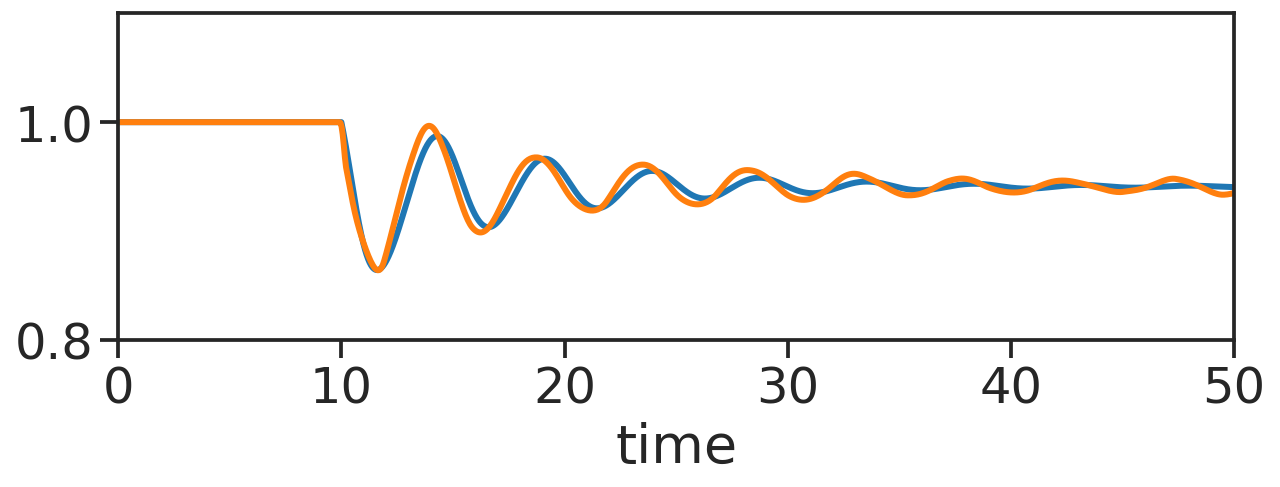

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(10,3))

ax.plot(tMPC,xMPC_traj[1],color='#1f77b4')
# ax.plot(tMPC,vMPC_traj[1],color='#1f77b4')
ax.plot(t,xtraj_list[0][1],color=colors[1])

ax.set_xlabel('time')
ax.set_ylim([.8,1.1])
ax.set_xlim([0,50])
# ax[1,1].plot(t,w_func(t),color='#ff7f0e',label='FBA') #this is because in this setting, steady state flux of both PK and PFK are equal to disturbance w.


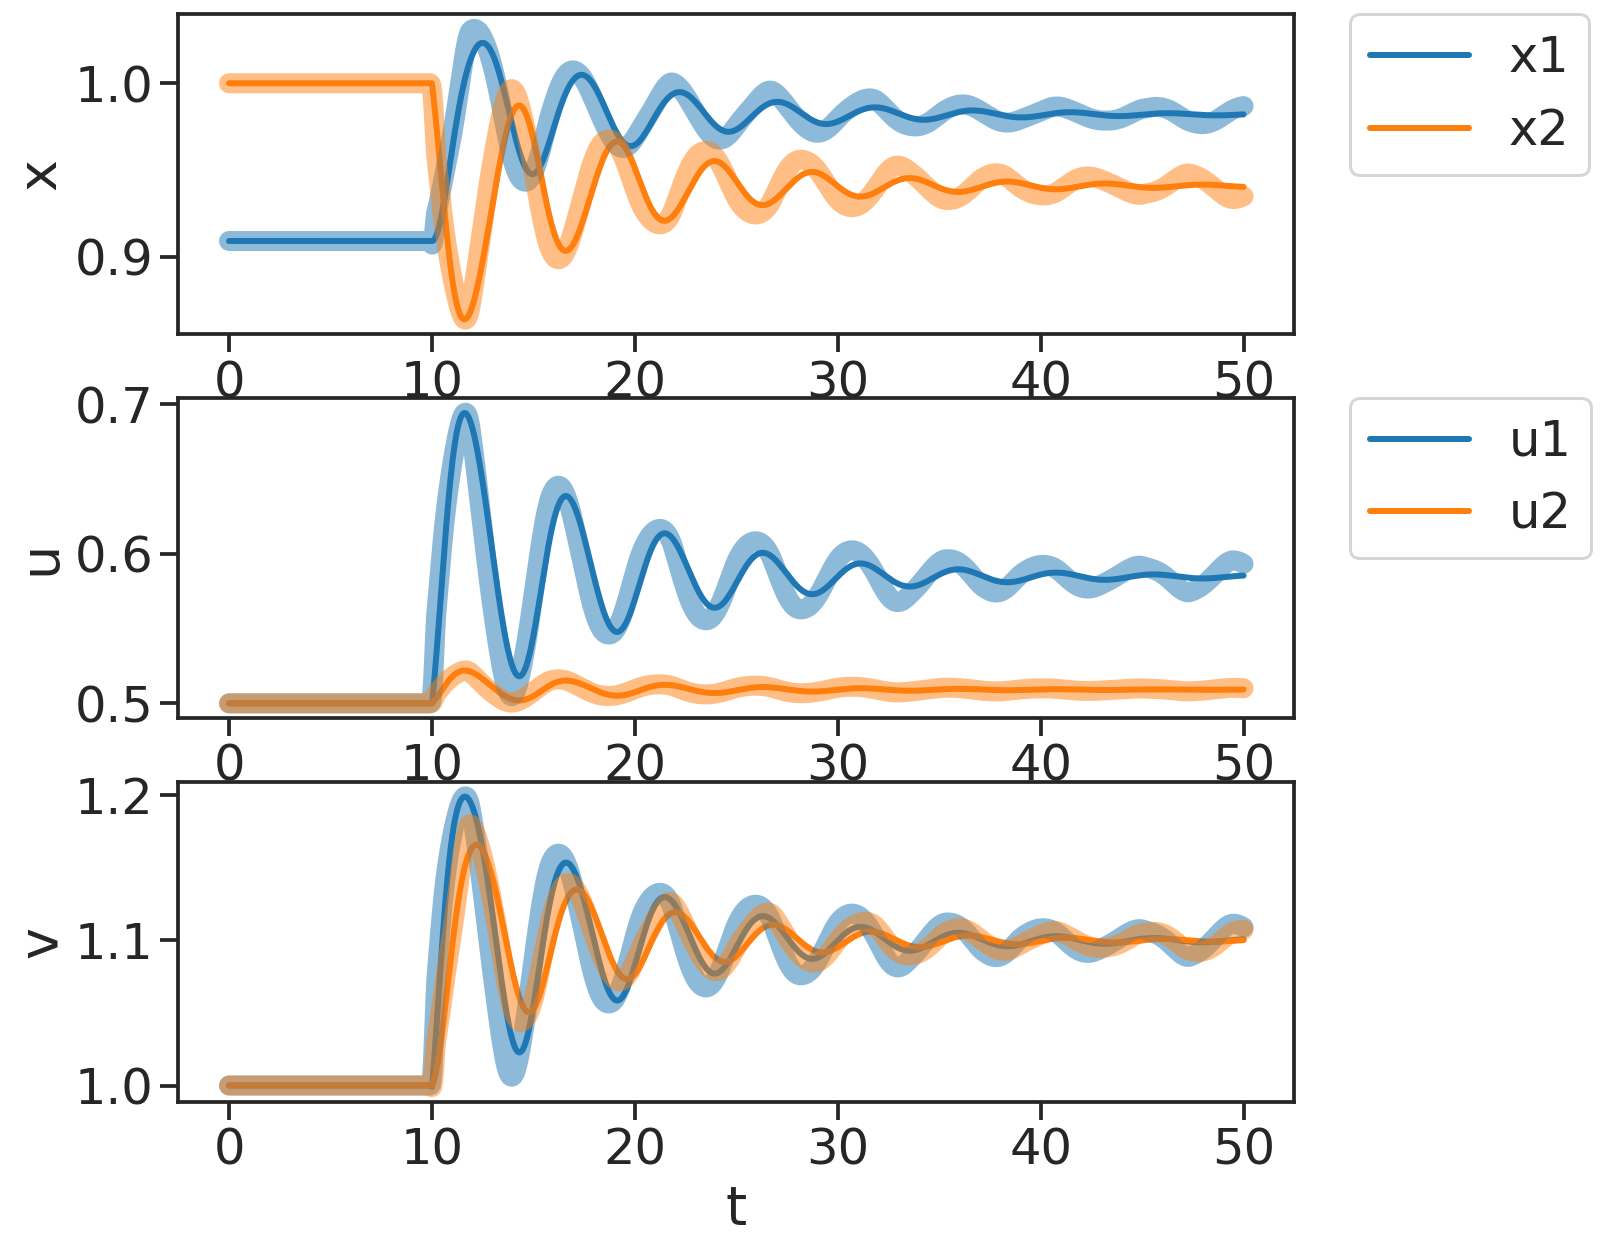

In [ ]:
fig, ax = plt.subplots(3, 1,figsize=(10,10))

ax[0].plot(tMPC,xMPC_traj[0],color=colors[0],label='x1')
ax[0].plot(tMPC,xMPC_traj[1],color=colors[1],label='x2')
ax[0].plot(t,xtraj_list[0][0],color=colors[0],lw=10,alpha=0.5)
ax[0].plot(t,xtraj_list[0][1],color=colors[1],lw=10,alpha=0.5)
ax[0].set_ylabel('x')
# ax[0].set_ylim([0.5,1.25])
ax[1].plot(tMPC,uMPC_traj[0],label='u1')
ax[1].plot(tMPC,uMPC_traj[1],label='u2')
ax[1].plot(t,utraj_list[0][0],color=colors[0],lw=10,alpha=0.5)
ax[1].plot(t,utraj_list[0][1],color=colors[1],lw=10,alpha=0.5)
ax[1].set_ylabel('u')

ax[2].plot(tMPC,vMPC_traj[0],label='v1')
ax[2].plot(tMPC,vMPC_traj[1],label='v2')
ax[2].plot(t,vtraj_list[0][0],color=colors[0],lw=10,alpha=0.5)
ax[2].plot(t,vtraj_list[0][1],color=colors[1],lw=10,alpha=0.5)
ax[2].set_ylabel('v')

ax[2].set_xlabel('t')

handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)
handles, labels = ax[1].get_legend_handles_labels()
lgd = ax[1].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)

### Solve next step control \\(u\\) by MPC.

The following is one way to compute \\(u\\) by solving an MPC problem in fold-change linearization variables.

In [ ]:
def AdBd_func(dt,x,u,w,HA,HB,v_std,S,Sw):
    v=v_func(x,u,HA,HB,v_std)
    f0=f_func(v,w,S,Sw)
    
    # continuous time A, B and b.
    Ac=np.diag(1/x).dot(S.dot(np.diag(v)).dot(HA))
    Bc=np.diag(1/x).dot(S.dot(np.diag(v)).dot(HB))
    bc=np.diag(1/x).dot(f0)

    Ad=sp.linalg.expm(Ac*dt)
    temp=np.linalg.inv(Ac).dot(Ad-np.eye(Ad.shape[0]))
    Bd=temp.dot(Bc)
    bd=temp.dot(bc)
    return Ad, Bd, bd

def MPC_prob_def(params_control):
    global dlogu,dlogx,logx_init,logu_init,logx_r,Ad,Bd,bb,prob

    N=params_control['N']
    x_min=params_control['x_min']
    x_max=params_control['x_max']
    # logu_min=params_control['logu_min']
    # logu_max=params_control['logu_max']
    nu=params_control['nu']
    nx=params_control['nx']
    Q=params_control['Q']
    R=params_control['R']
    
    # Define problem
    dlogu = cp.Variable((nu, N))
    dlogx = cp.Variable((nx, N+1))
    logx_init = cp.Parameter(nx)
    logu_init = cp.Parameter(nu)
    logx_r = cp.Parameter(nx)
    logu_r = cp.Parameter(nu)
    Ad=cp.Parameter((nx,nx))
    Bd=cp.Parameter((nx,nu))
    bb=cp.Parameter(nx)
    objective = 0
    constraints = [dlogx[:,0] == np.zeros(nx)]
    #the optimization variable dlogx is predicted change to logx_init, so 
    # logx_init+dlogx(t) = dlogx(t).
    for k in range(N):
        #penalize deviation of x from xr
        objective += cp.quad_form(logx_init+dlogx[:,k] - logx_r, Q)

        # penalize change in u from u(t)
        # objective += cp.quad_form(dlogu[:,k], R) 

        # penalize time derivative of u, usually R need to scale up by like 20 fold.
        if k==0:
          objective += cp.quad_form(dlogu[:,k], R) 
        else:
          objective += cp.quad_form(dlogu[:,k] - dlogu[:,k-1], R) 

        constraints += [dlogx[:,k+1] == bb + Ad@dlogx[:,k] + Bd@dlogu[:,k]]
        constraints += [cp.log(x_min) <= logx_init+dlogx[:,k], logx_init+dlogx[:,k] <= cp.log(x_max)]
        # constraints += [logu_init+dlogu_min <= logu[:,k], logu_init+dlogu[:,k] <= logu_max]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    return prob

# def MPC_prob_def(params_control):
#     global dlogu,dx,x_init,logu_init,x_r,Ad,Bd,bb,prob

#     N=params_control['N']
#     x_min=params_control['x_min']
#     x_max=params_control['x_max']
#     dlogu_min=params_control['dlogu_min']
#     dlogu_max=params_control['dlogu_max']
#     nu=params_control['nu']
#     nx=params_control['nx']
#     Q=params_control['Q']
#     R=params_control['R']
    
#     # Define problem
#     dlogu = cp.Variable((nu, N))
#     dx = cp.Variable((nx, N+1))
#     x_init = cp.Parameter(nx)
#     logu_init = cp.Parameter(nu)
#     x_r = cp.Parameter(nx)
#     Ad=cp.Parameter((nx,nx))
#     Bd=cp.Parameter((nx,nu))
#     bb=cp.Parameter(nx)
#     objective = 0
#     constraints = [dx[:,0] == np.zeros(nx)]
#     #the optimization variable dx is predicted change to x_init, so x_init+dx(t) = x(t).
#     for k in range(N):
#         #penalize deviation of x from xr
#         #penalize changes in u.
#         x_traj=x_init+dx[:,k]
#         objective += cp.quad_form(x_traj - x_r, Q) + cp.quad_form(dlogu[:,k], R)
#         constraints += [dlogx[:,k+1] == bb + Ad@dlogx[:,k] + Bd@dlogu[:,k]]
#         constraints += [x_min <= x_traj, x_traj <= x_max]
#         constraints += [dlogu_min <= dlogu[:,k], dlogu[:,k] <= dlogu_max]
#     # objective += cvxpy.quad_form(cvxpy.atoms.sum(x,axis=1) - xr, QN)
#     prob = cp.Problem(cp.Minimize(objective), constraints)
#     return prob

def u_func_MPC(t,x_now,u_now,params_control,params_sys):
    dt_pred=params_control['dt_pred']
    # if this is the first time, define the MPC prediction horizon problem.
    if params_control['prob_not_formulated']:
        # Prediction horizon.
        T = params_control['T']
        N=int(T/dt_pred)
        params_control['N']=N
        prob=MPC_prob_def(params_control)
        params_control['prob_not_formulated']=False
        params_control['prob']=prob
        # set_trace()
    prob=params_control['prob']    
    xr_func=params_control['xr_func']
    HA=params_sys['HA']
    HB=params_sys['HB']
    v_std=params_sys['v_std']
    w=params_sys['w_func'](t)
    S=params_sys['S']
    Sw=params_sys['Sw']
    logx_r.value=np.log(np.array(xr_func(t)))
    logx_init.value = np.log(x_now)
    # x_r.value=np.array(xr_func(t))
    # x_init.value = x_now
    logu_init.value = np.log(u_now)
    Ad.value,Bd.value,bb.value= AdBd_func(dt_pred,x_now,u_now,w,HA,HB,v_std,S,Sw) #linearize at current position
    prob.solve(solver=cp.OSQP,warm_start=True) #solve LQR based on linearized model for optimal strategy to use at current step
    if prob.status != 'optimal': # not feasible, raise stop flag to exit MPC calculation.
      stop_flag=True
      return u_now, stop_flag
    # prob.solve(solver='GUROBI',warm_start=True)
    else:
      dlogu_next=dlogu[:,0].value
      du=u_now*(np.exp(dlogu_next)-1) # converts dlogu into du
      stop_flag=False
      return du,stop_flag


In [ ]:

k_param=1.1
q=1

h=2.8
g=.3
x1=1

t_disturb=0

params_sys={
    'S':np.array([[1,-1],[-q,1+q]]),
    'Sw':np.array([0,-1]),

    'v_std':np.array([2,2*k_param]),
    'HA':np.array([[0,1],[1,0]]),
    'HB':np.eye(2),
    'w_func': lambda t:1+(t>t_disturb)*0.1
}


t_init=-10
t_end=40
dt=.03
params_sim={
    't_init':t_init,
    't_end':t_end,
    'dt':dt,
    # Initial and reference states
    'x0' : np.array([1/k_param,1]),
    'u0' : np.exp(np.array([-.695,-.695])),
    # 'u0': np.array([1/(1+x1**(2*h)), 1/(1+x1**(2*g))])
}

dt_pred=dt

nx=params_sys['HA'].shape[1]
nv=params_sys['HA'].shape[0]
nu=params_sys['HB'].shape[1]
params_control={
    'xr_func': lambda t:[1/k_param+(t>t_disturb)*0.07,1-(t>t_disturb)*0.07],
    'nx':nx,
    'nu':nu,
    'nv':nv,
    # Prediction horizon
    'T' : .6,
    'dt_pred':dt_pred,
    # 'R':sp.sparse.diags([.4,.45]),
    # 'R':sp.sparse.diags([.4,.05]),
    'R':sp.sparse.diags([5,3]),
    'Q' : sp.sparse.diags([.3, .08]),
    # 'dlogu_min' : np.array([-np.inf,-np.inf]),
    # 'dlogu_max' : np.array([np.inf,np.inf]),
    'x_min' : np.array([1e-3,.6]),
    'x_max' : np.array([np.inf,np.inf]),
    'prob_not_formulated':True
}

u_func = lambda t,x,u:u_func_MPC(t,x,u,params_control,params_sys)

In [ ]:
xMPC_traj,uMPC_traj,vMPC_traj,tMPC=MPC_sim(u_func,params_sim,params_sys)

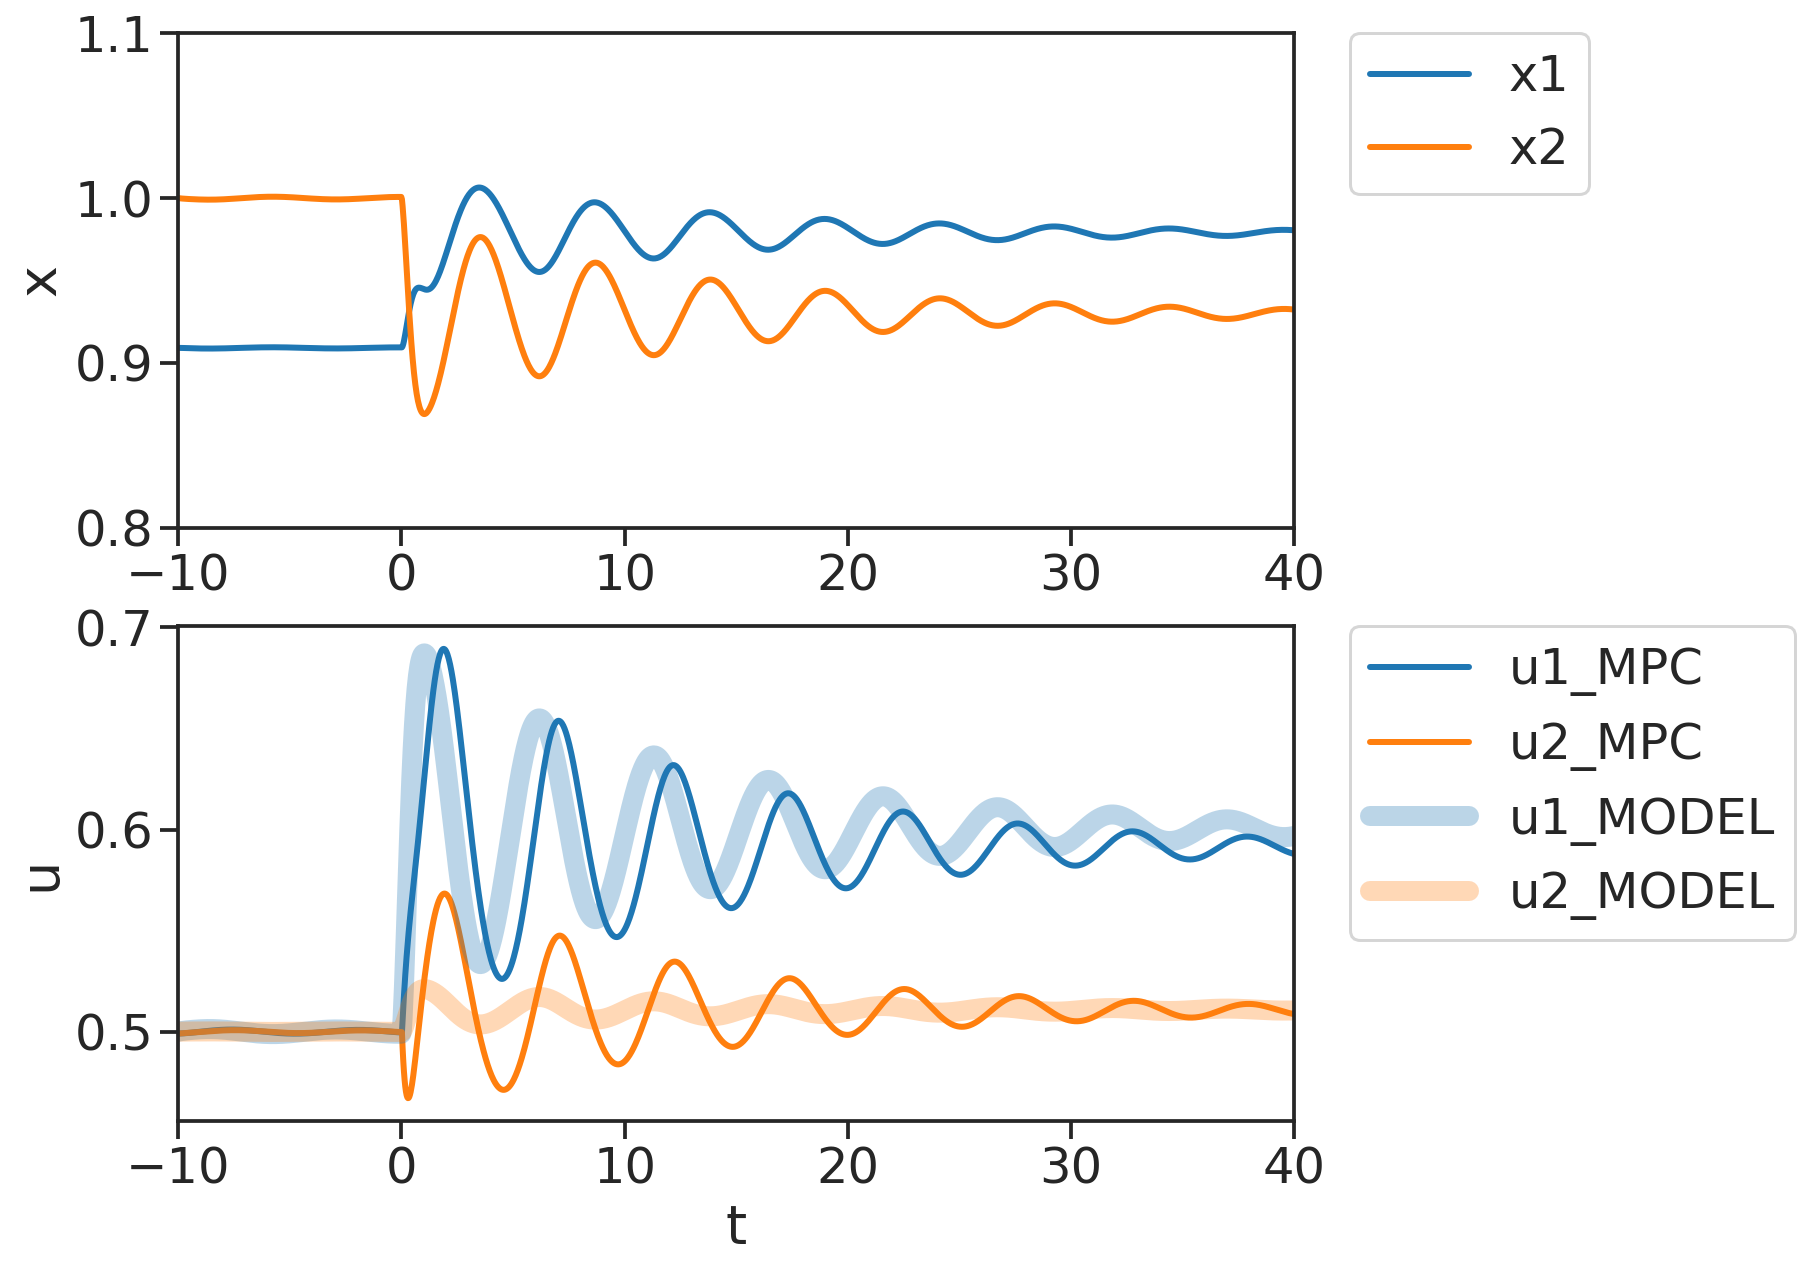

In [ ]:
fig, ax = plt.subplots(2, 1,figsize=(10,10))

ax[0].plot(tMPC,xMPC_traj[0],color=colors[0],label='x1')
ax[0].plot(tMPC,xMPC_traj[1],color=colors[1],label='x2')

x_threshold=0.6
ax[0].plot(tMPC[[0,-1]],np.ones(2)*x_threshold,'r')

ax[0].set_ylabel('x')
ax[0].set_ylim([0.8,1.1])
ax[0].set_xlim([t_init,t_end])

ax[1].plot(tMPC,uMPC_traj[0],label='u1_MPC')
ax[1].plot(tMPC,uMPC_traj[1],label='u2_MPC')
ax[1].set_xlim([t_init,t_end])
# ax[1].set_ylim([0,1])

h=2.8
g=.3
uMODEL_traj=np.array([1/(1+xMPC_traj[1]**(2*h)), 1/(1+xMPC_traj[1]**(2*g))])
ax[1].plot(tMPC,uMODEL_traj[0],color=colors[0],lw=10,alpha=.3,label='u1_MODEL')
ax[1].plot(tMPC,uMODEL_traj[1],color=colors[1],lw=10,alpha=.3,label='u2_MODEL')


ax[1].set_xlabel('t')
ax[1].set_ylabel('u')
handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)
handles, labels = ax[1].get_legend_handles_labels()
lgd = ax[1].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)

In [ ]:
# R_list=[sp.sparse.diags([1,5]),sp.sparse.diags([3.5,5]),sp.sparse.diags([10,5])]
R_list=[sp.sparse.diags([3,3]),sp.sparse.diags([4.25,4.25]),sp.sparse.diags([5.5,5.5])]

xMPC_traj_list=[]
uMPC_traj_list=[]
vMPC_traj_list=[]

for R in R_list:
    params_control['R']=R
    params_control['prob_not_formulated']=True
    u_func = lambda t,x,u:u_func_MPC(t,x,u,params_control,params_sys)  
    xMPC_traj,uMPC_traj,vMPC_traj,tMPC=MPC_sim(u_func,params_sim,params_sys)
    xMPC_traj_list=xMPC_traj_list+[xMPC_traj]
    uMPC_traj_list=uMPC_traj_list+[uMPC_traj]
    vMPC_traj_list=vMPC_traj_list+[vMPC_traj]
print('done')

done


<ipython-input-108-ab5fc1190cdb>:22: RuntimeWarning: invalid value encountered in double_scalars
  c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])


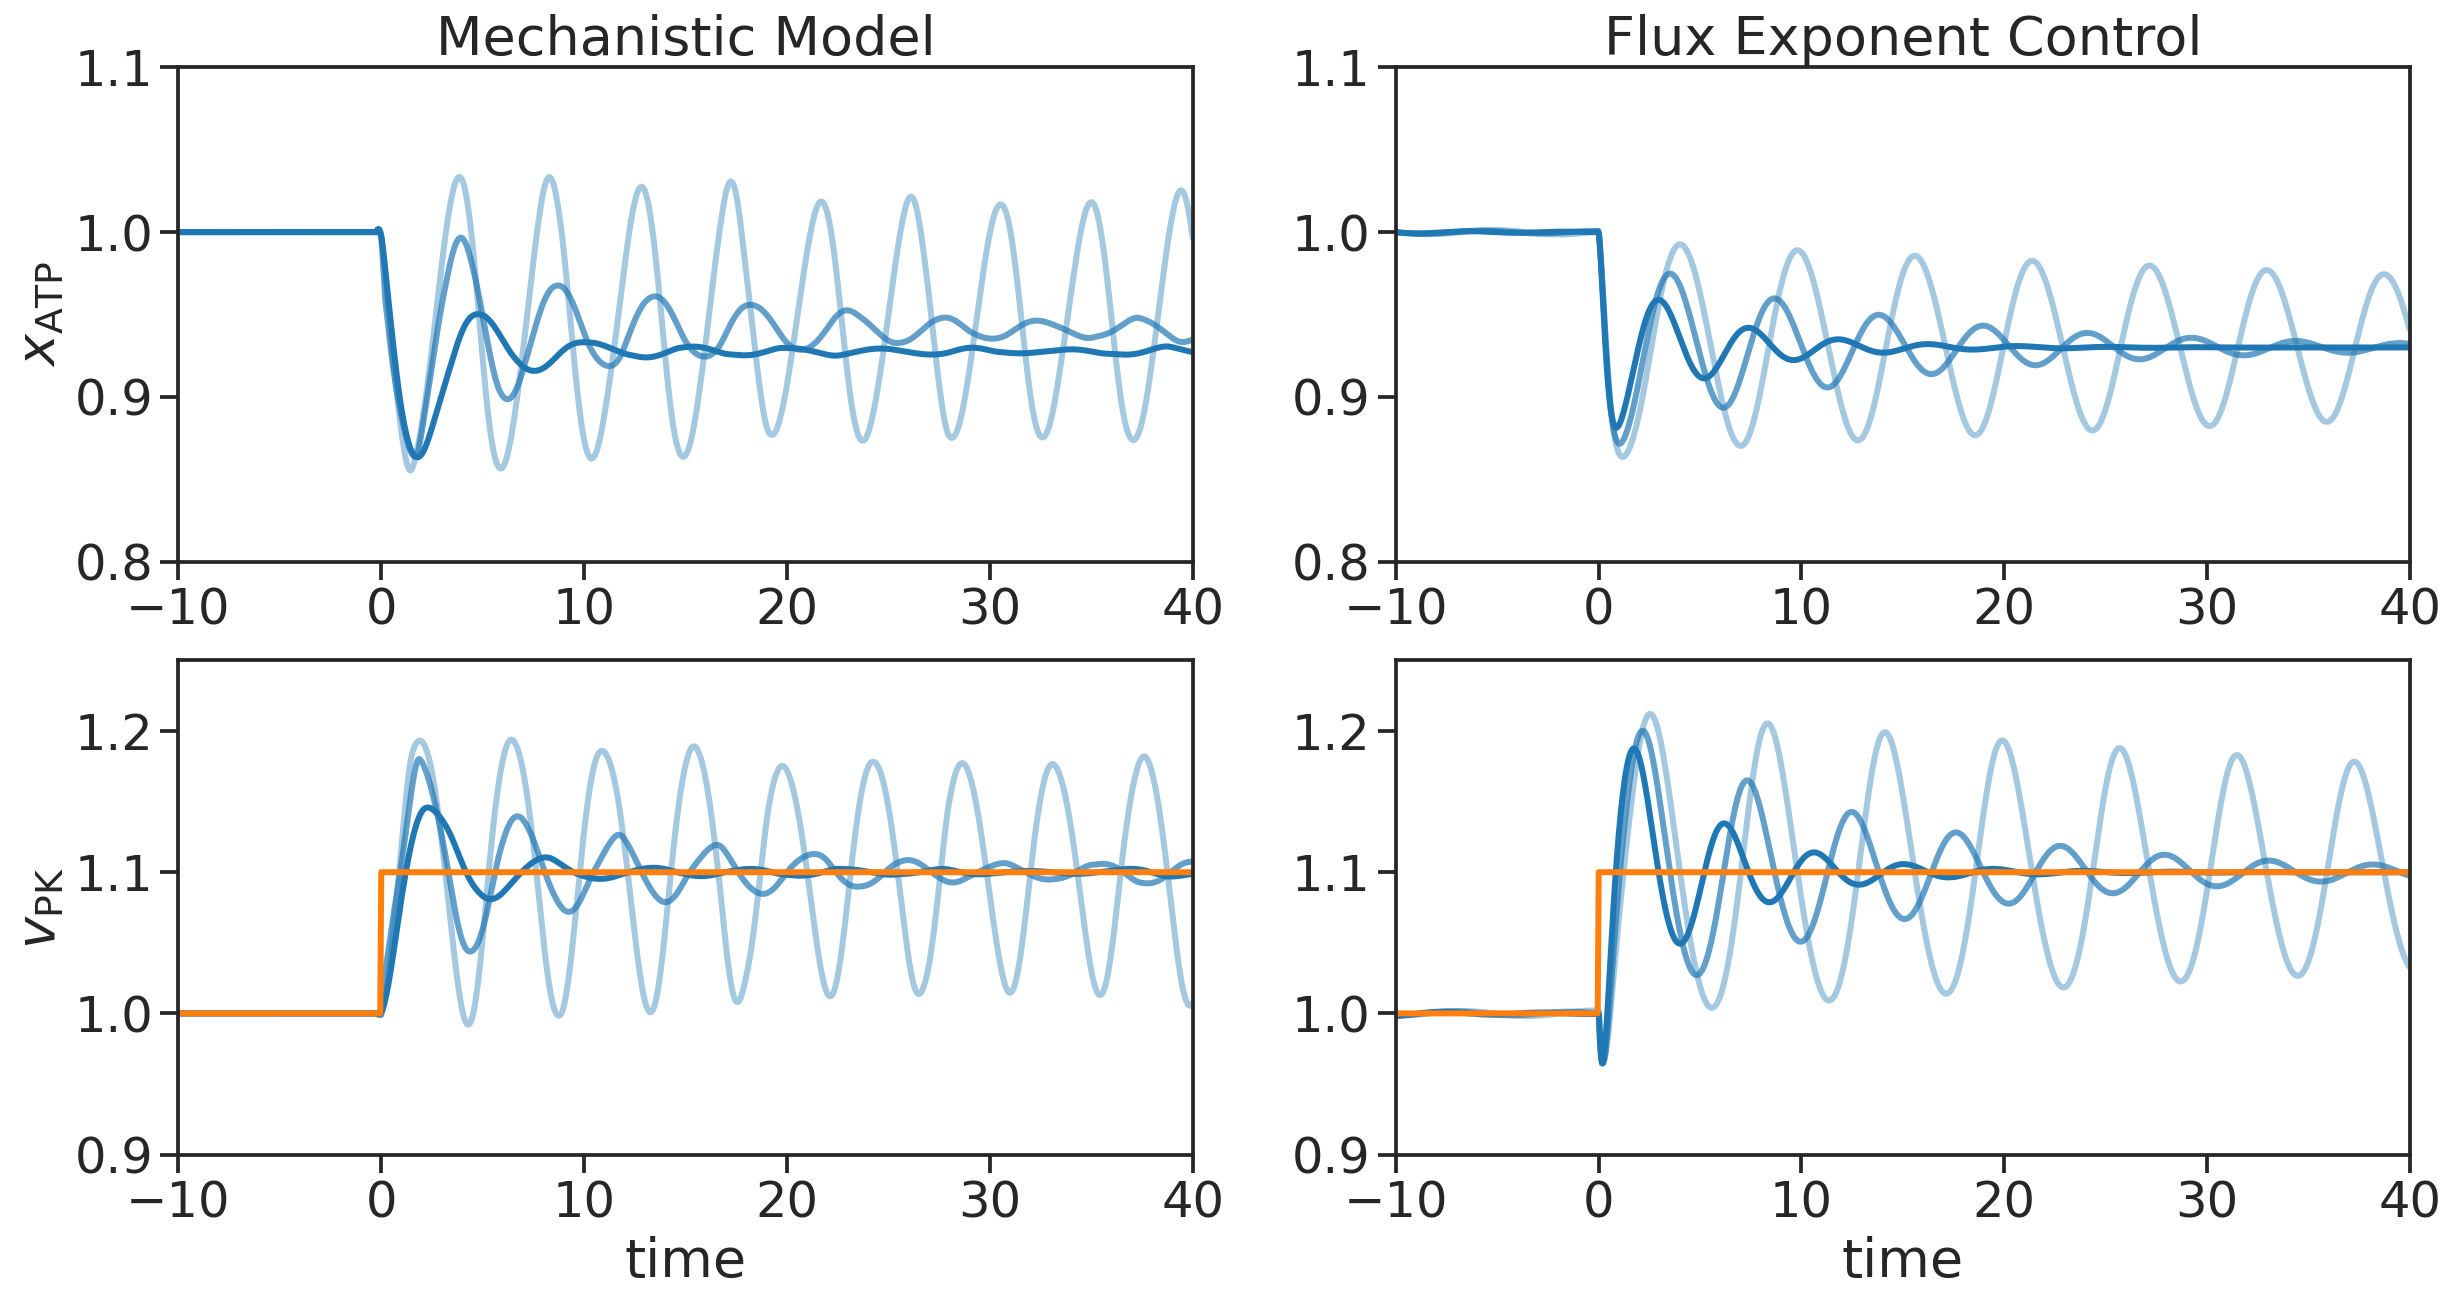

In [ ]:
a=1
q=1
k=1.1
K=np.diag([2,2*k])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]]) # order is PFK, PK.
Sw=np.array([0,-1])
# w_func=lambda t:1.1

h=2.8
g=.3

params={'a':a,'h':h,'g':g,'K':K,'k':k}


def df2(t,x,w_func,S,Sw,params):
    a=params['a']
    h=params['h']
    g=params['g']
    K=params['K']
    c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])
    v=K.dot(c)
    return S.dot(v)+Sw.dot(w_func(t))

h_list=[2.5,2.8,3.1]
params_list=[params.copy() for i in h_list]
for a,h in zip(params_list,h_list):
    a['h']=h

t_end=40
t_init=-10
t_disturb=0
w_func=lambda t:1+(t>t_disturb)*0.1

n_pts=1000
t=np.linspace(t_init,t_end,n_pts)
n_params=len(params_list)
n_dim=2
xtraj_list=np.zeros((n_params,n_dim,n_pts))
utraj_list=np.zeros((n_params,n_dim,n_pts))
vtraj_list=np.zeros((n_params,n_dim,n_pts))
for i,params in zip(range(n_params),params_list):
    f=lambda t,x:df2(t,x,w_func,S,Sw,params)
    k=params['k']
    a=params['a']
    h=params['h']
    g=params['g']
    K=params['K']
    x0=[1/k,1]
    sol = sp.integrate.solve_ivp(f, [t_init,t_end], x0, t_eval=t)
#     import pdb
#     pdb.set_trace()
    xtraj=sol.y
    xtraj_list[i]=xtraj
    utraj=np.array([np.log(1/(1+xtraj[1]**(2*h))),np.log(1/(1+xtraj[1]**(2*g)))])
    ctraj=np.array([xtraj[1]**a/(1+xtraj[1]**(2*h)), xtraj[0]/(1+xtraj[1]**(2*g))])
#     import pdb
#     pdb.set_trace()
    vtraj=K.dot(ctraj)
    vtraj_list[i]=vtraj
    utraj_list[i]=utraj
    

fig, ax = plt.subplots(2, 2,figsize=(20,10))
for i in range(n_params):
    ax[0,0].plot(t,xtraj_list[i][1],color='#1f77b4',alpha=1-0.3*i)
    ax[1,0].plot(t,vtraj_list[i][1],color='#1f77b4',alpha=1-0.3*i)
ax[0,0].set_ylabel(r'$x_{\mathrm{ATP}}$')
ax[0,0].set_ylim([0.8,1.1])
ax[0,0].set_xlim([t_init,t_end])
ax[0,0].set_title('Mechanistic Model')

ax[1,0].set_xlabel('time')
ax[1,0].set_ylabel(r'$v_{\mathrm{PK}}$')
ax[1,0].set_ylim([.9,1.25])
ax[1,0].set_xlim([t_init,t_end])

ax[1,0].plot(t,w_func(t),color='#ff7f0e',label='FBA') #this is because in this setting, steady state flux of both PK and PFK are equal to disturbance w.


for i in range(len(R_list)):
    ax[0,1].plot(tMPC,xMPC_traj_list[i][1],color='#1f77b4',alpha=1-0.3*i)
    ax[1,1].plot(tMPC,vMPC_traj_list[i][1],color='#1f77b4',alpha=1-.3*i)

ax[0,1].set_ylim([0.8,1.1])
ax[0,1].set_xlim([t_init,t_end])
ax[0,1].set_title('Flux Exponent Control')

ax[1,1].set_xlabel('time')
ax[1,1].set_ylim([.9,1.25])
ax[1,1].set_xlim([t_init,t_end])
ax[1,1].plot(t,w_func(t),color='#ff7f0e',label='FBA') #this is because in this setting, steady state flux of both PK and PFK are equal to disturbance w.

plt.savefig('glycolytic-oscillation-mpc-comparison.png',bbox_inches='tight')

In [ ]:
from google.colab import files
files.download('glycolytic-oscillation-mpc-comparison.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>